# notebook mnist

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from lib.callbacks import *
from lib.model import *
from lib.data import *
from lib.optimizers import *
from pathlib import Path

## MNIST data

In [4]:
x_train,y_train,x_valid,y_valid = get_mnist_data(Path("/Users/kasparlund/.fastai/data/mnist.pkl.gz"))
x_train,x_valid   = normalize_to(x_train,x_valid)

x_train.mean(),x_train.std()

(tensor(-7.6999e-06), tensor(1.))

In [6]:
in_features         = 1
nh,bs,out_features  = 50,512,y_train.max().item()+1
train_ds,valid_ds   = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
train_dl, valid_dl  = ( DataLoader( train_ds, batch_size=bs, shuffle=True), 
                        DataLoader(valid_ds,  batch_size=bs*2) )
data                = DataBunch( train_dl, valid_dl )

In [7]:
mnist_view = view_tfm(1,28,28)
layers_sizes = [8,16,32,32]
loss_func = F.cross_entropy
sched     = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback,
#             partial(ParamScheduler, 'lr', sched),             
             partial(BatchTransformXCallback, tfm = mnist_view),
             ProgressCallback]

## mnist without kaiming initialization

In [8]:
cbfs  = cbfs_base.copy() + [LR_Finder]
model = get_cnn_model(layers_sizes, in_features, out_features, partial(conv_layer,bn=False) )
learn = Learner( model, data, loss_func, opt=SGD(sched,max_lr=0.5, max_wd=0.01), cb_funcs=cbfs)
%time learn.fit(1)

CPU times: user 18.4 s, sys: 4.03 s, total: 22.4 s
Wall time: 3.32 s


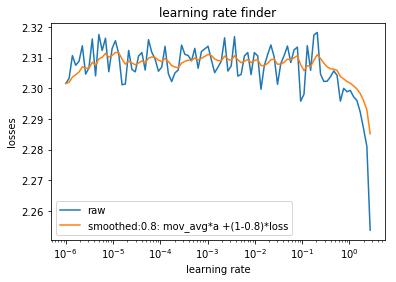

(None, None)

In [10]:
learn.find_subcription_by_cls(LR_Finder).plot_loss(0,5),plt.show()
#learn.find_subcription_by_cls(LR_Finder).plot_lr()

In [11]:
#Training: create model again because current LRFInd does not restore settings in model and opt
cbfs      = cbfs_base.copy()+[Recorder, partial(AvgStatsCallback,[accuracy])]
model     = get_cnn_model(layers_sizes, in_features, out_features, partial(conv_layer,bn=False) )
learn     = Learner( model, data, loss_func,opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)
%time learn.fit(4)

train: [2.27627203125, tensor(0.1576)]
valid: [1.6684587890625, tensor(0.5415)]
train: [1.04866625, tensor(0.6698)]
valid: [0.3319402099609375, tensor(0.9034)]
train: [0.28490376953125, tensor(0.9157)]
valid: [0.1970927734375, tensor(0.9428)]
train: [0.188275390625, tensor(0.9441)]
valid: [0.173442431640625, tensor(0.9494)]
CPU times: user 1min 15s, sys: 19.8 s, total: 1min 35s
Wall time: 14.5 s


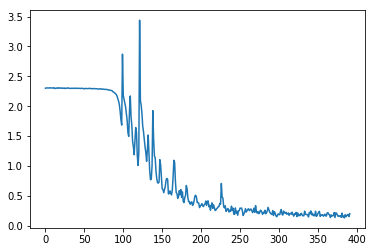

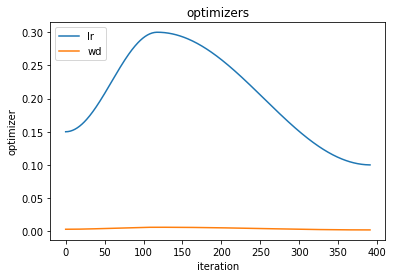

tensor(0.1604)

In [13]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.loss

## mnist with hooks

In [14]:
sched     = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback,
             partial(BatchTransformXCallback, tfm = mnist_view) ]

train: [2.27346421875, tensor(0.1927)]
valid: [2.173038671875, tensor(0.3084)]
train: [1.34557359375, tensor(0.5799)]
valid: [0.47978896484375, tensor(0.8540)]
train: [0.3363603515625, tensor(0.9001)]
valid: [0.18891209716796875, tensor(0.9459)]
train: [0.1741147265625, tensor(0.9487)]
valid: [0.14565653076171875, tensor(0.9570)]


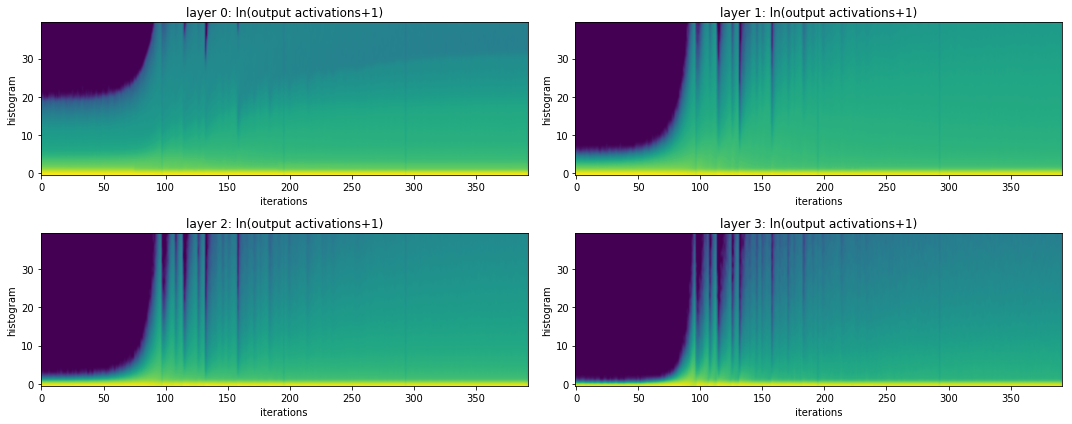

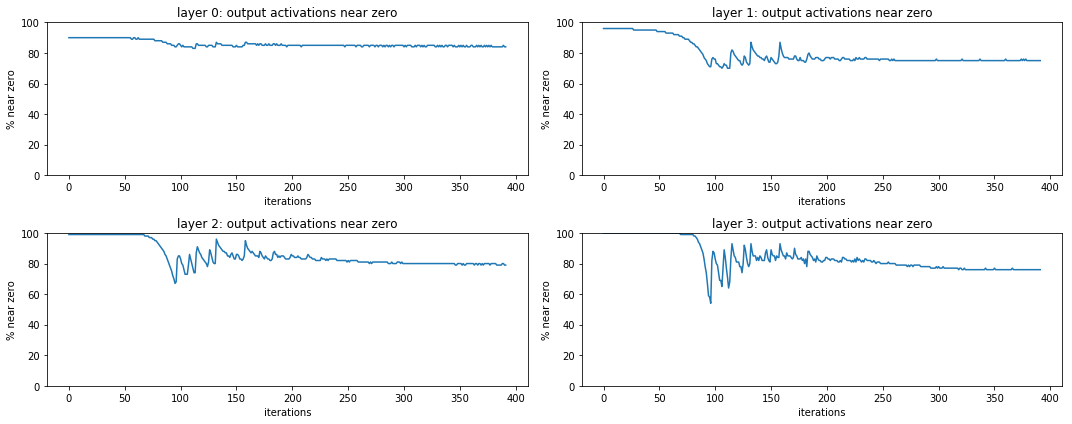

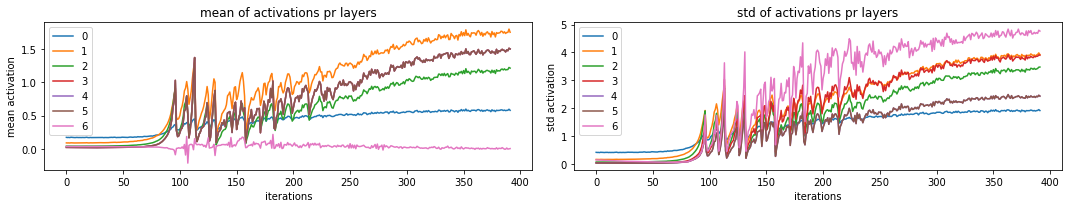

In [16]:
cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
model = get_cnn_model(layers_sizes, in_features, out_features, partial(conv_layer,bn=False) )
learn = Learner( model, data, loss_func,opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)
with Hooks(model, append_stats) as hooks: 
    learn.fit(4)
    plot_layer_stats( hooks )

## mnist with hooks and kaiming initialization

train: [1.206867109375, tensor(0.6278)]
valid: [0.769157470703125, tensor(0.7553)]
train: [0.378370703125, tensor(0.8857)]
valid: [0.232306884765625, tensor(0.9279)]
train: [0.21233611328125, tensor(0.9378)]
valid: [0.1424805419921875, tensor(0.9600)]
train: [0.12830626953125, tensor(0.9614)]
valid: [0.111965234375, tensor(0.9669)]


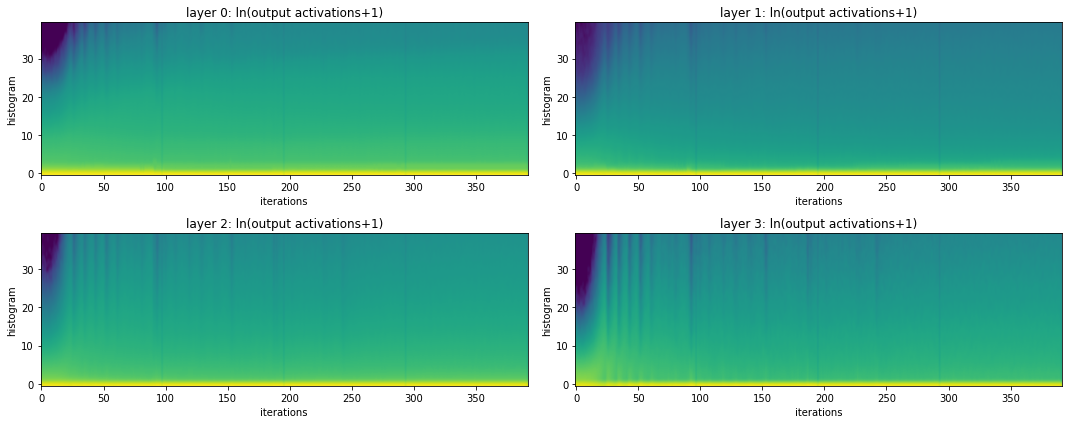

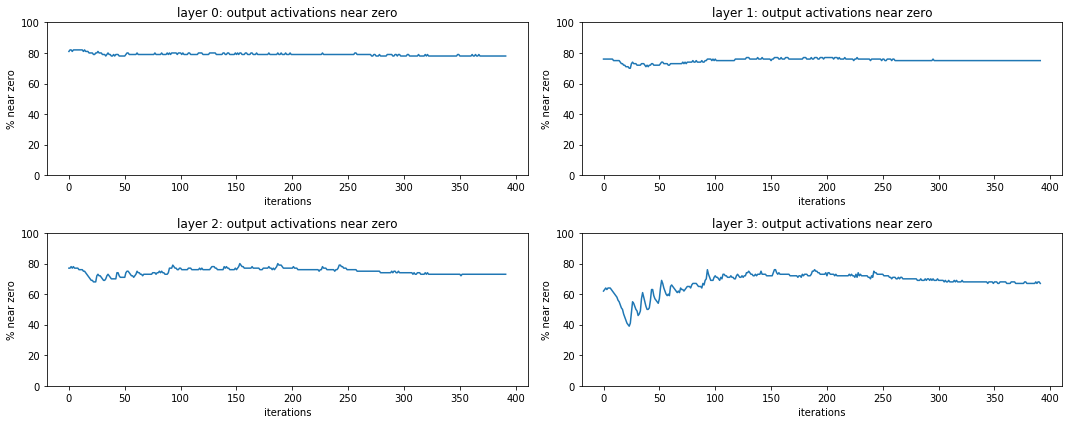

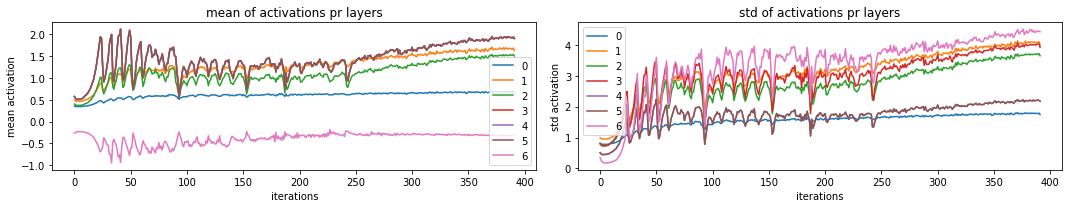

In [17]:
cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
model = get_cnn_model(layers_sizes, in_features, out_features, partial(conv_layer,bn=False) )
init_cnn(model)
learn = Learner( model, data, loss_func,opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)

with Hooks(model, append_stats) as hooks: 
    learn.fit(4)
    plot_layer_stats( hooks )

## mnist with hooks + kaiming initialization + batchnorm

train: [1.38690984375, tensor(0.6178)]
valid: [0.40275263671875, tensor(0.9060)]
train: [0.2430722265625, tensor(0.9355)]
valid: [0.1549785888671875, tensor(0.9535)]
train: [0.12213529296875, tensor(0.9651)]
valid: [0.10046256713867187, tensor(0.9704)]
train: [0.088933095703125, tensor(0.9755)]
valid: [0.08739070434570312, tensor(0.9752)]


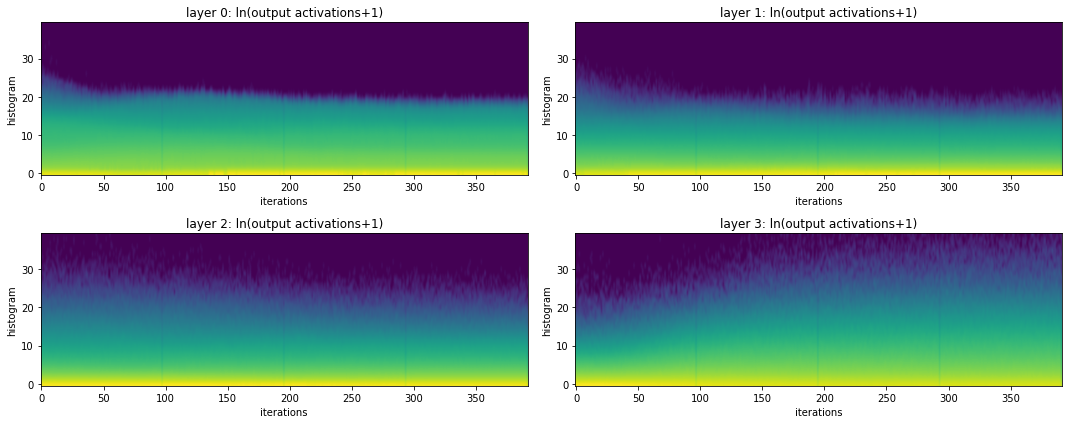

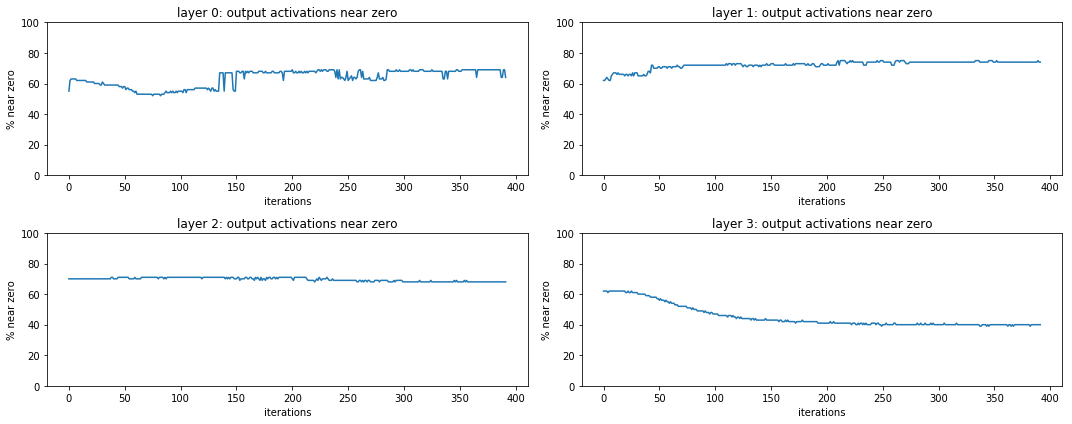

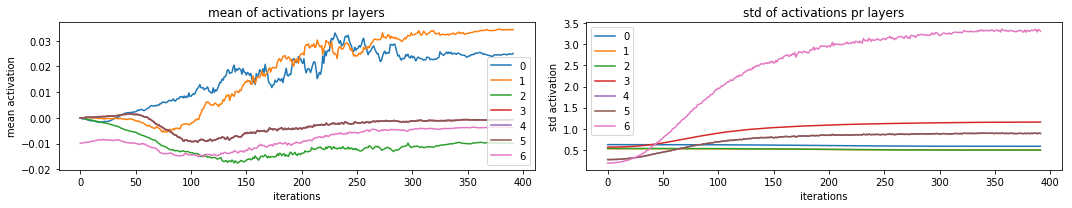

In [19]:
cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
model = get_cnn_model(layers_sizes, in_features, out_features, partial(conv_layer,bn=True) )
init_cnn(model)
learn = Learner( model, data, loss_func,opt=SGD(sched,max_lr=0.5, max_wd=1e-3), cb_funcs=cbfs)

with Hooks(model, append_stats) as hooks: 
    learn.fit(4)
    plot_layer_stats( hooks )